# HMS - Harmful Brain Activity Seizure Classification

The goal of this competition is to detect and classify seizures and other types of harmful brain activity in electroencephalography (EEG) data. Even experts find this to be a challenging task and often disagree about the correct labels.

So, we build a different models with different targets which can give us a better viewpoint for prediction and classification.t.

In [3]:
'''
Load the Libaries
'''

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [3]:
# Load the Data

df = pd.read_csv("train.csv")
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


## Perform Exploratory Data Analysis

In [4]:
df.dtypes

eeg_id                                int64
eeg_sub_id                            int64
eeg_label_offset_seconds            float64
spectrogram_id                        int64
spectrogram_sub_id                    int64
spectrogram_label_offset_seconds    float64
label_id                              int64
patient_id                            int64
expert_consensus                     object
seizure_vote                          int64
lpd_vote                              int64
gpd_vote                              int64
lrda_vote                             int64
grda_vote                             int64
other_vote                            int64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          106800 non-null  i

In [6]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
106795    False
106796    False
106797    False
106798    False
106799    False
Length: 106800, dtype: bool

We group the data according to both the eeg and spectrogram ids and patient id

In [7]:
print("For each eeg and spectrogram, there is a unique patient")
print(df.groupby("eeg_id").patient_id.nunique().value_counts())
print(df.groupby("spectrogram_id").patient_id.nunique().value_counts())

print()
print("-" * 100)
print("But one patient can be recorded several times")
print(df.groupby("patient_id").eeg_id.nunique().sort_values(ascending=False))
print(df.groupby("patient_id").spectrogram_id.nunique().sort_values(ascending=False))

For each eeg and spectrogram, there is a unique patient
patient_id
1    17089
Name: count, dtype: int64
patient_id
1    11138
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
But one patient can be recorded several times
patient_id
30631    270
28330    250
38549    205
35225    189
56450    182
        ... 
55045      1
55039      1
41529      1
54991      1
48691      1
Name: eeg_id, Length: 1950, dtype: int64
patient_id
30631    66
56450    66
35627    58
12251    58
14965    54
         ..
36402     1
55361     1
23629     1
47258     1
43409     1
Name: spectrogram_id, Length: 1950, dtype: int64


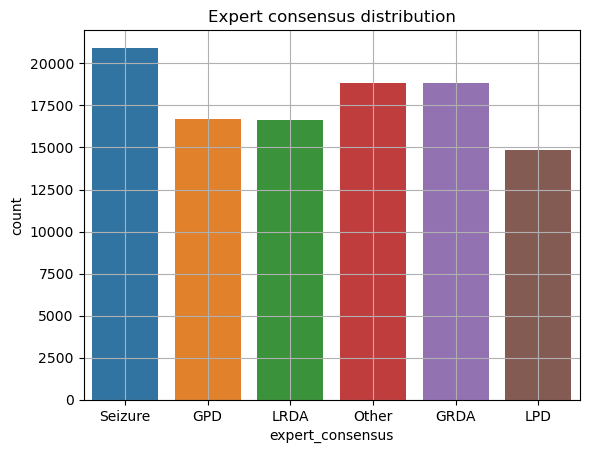

In [8]:
# distribution of pattern seems to be balanced
fig = plt.figure()
ax = sns.countplot(
    x="expert_consensus",
    data=df,
    dodge=False
)
ax.get_legend()
plt.title("Expert consensus distribution")
plt.grid()

In [9]:
df.nunique()

eeg_id                               17089
eeg_sub_id                             743
eeg_label_offset_seconds              1502
spectrogram_id                       11138
spectrogram_sub_id                    1022
spectrogram_label_offset_seconds      4686
label_id                            106800
patient_id                            1950
expert_consensus                         6
seizure_vote                            18
lpd_vote                                19
gpd_vote                                17
lrda_vote                               16
grda_vote                               16
other_vote                              26
dtype: int64

In [10]:
# spectrogram with several eegs
print(df.groupby("spectrogram_id").eeg_id.nunique().sort_values(ascending=False))
print()
print("-" * 100)
print()
df[df.spectrogram_id == 764146759]

spectrogram_id
764146759     107
1863712617     62
1940415234     54
2060670605     54
1908433744     53
             ... 
785799870       1
785887017       1
786484660       1
786569108       1
2147388374      1
Name: eeg_id, Length: 11138, dtype: int64

----------------------------------------------------------------------------------------------------



,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
38904,539866621,0,0.0,764146759,0,0.0,1115897925,30631,LPD,0,1,0,1,0,0
38905,1270973624,0,0.0,764146759,1,82.0,1345524852,30631,LPD,0,4,0,1,0,0
38906,1270973624,1,6.0,764146759,2,88.0,2464085157,30631,LPD,0,4,0,1,0,0
38907,1270973624,2,8.0,764146759,3,90.0,598535481,30631,LPD,0,4,0,1,0,0
38908,1270973624,3,12.0,764146759,4,94.0,3353171059,30631,LPD,0,4,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39921,2943834611,15,66.0,764146759,1017,17622.0,942313336,30631,LRDA,0,4,0,7,0,4
39922,2943834611,16,68.0,764146759,1018,17624.0,4028157645,30631,LRDA,0,4,0,7,0,4
39923,2943834611,17,70.0,764146759,1019,17626.0,2904817771,30631,LRDA,0,4,0,7,0,4
39924,2943834611,18,74.0,764146759,1020,17630.0,1142705888,30631,LRDA,0,4,0,7,0,4


### Exploring one patient's data

In [12]:
patient_id = 30631
patient_id_df = df.loc[lambda df: df["patient_id"] == patient_id]

In [13]:
patient_id_df["eeg_id"].value_counts()

eeg_id
1098299532    77
716712549     68
1062096035    65
2740228851    60
1315636310    49
              ..
2258476127     1
4049507367     1
577862428      1
4002813910     1
2811326032     1
Name: count, Length: 270, dtype: int64

In [14]:
eeg_id = 1098299532
s = patient_id_df.loc[lambda df: df["eeg_id"] == eeg_id]

<Axes: xlabel='eeg_label_offset_seconds'>

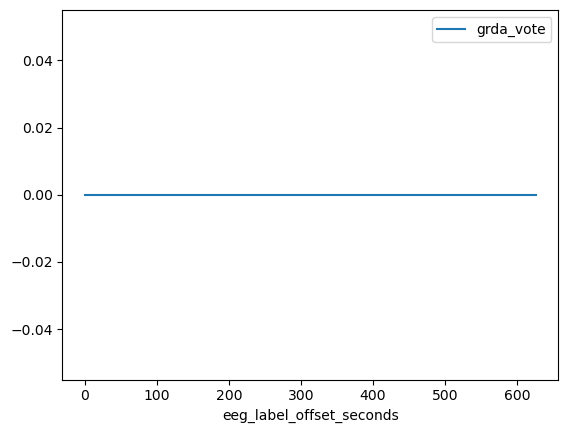

In [15]:
s[["eeg_label_offset_seconds", "grda_vote"]].set_index("eeg_label_offset_seconds").plot()

<Axes: xlabel='eeg_label_offset_seconds'>

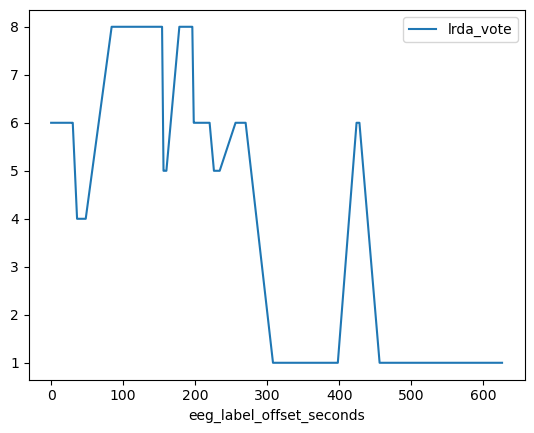

In [16]:
s[["eeg_label_offset_seconds", "lrda_vote"]].set_index("eeg_label_offset_seconds").plot()

<Axes: xlabel='spectrogram_label_offset_seconds'>

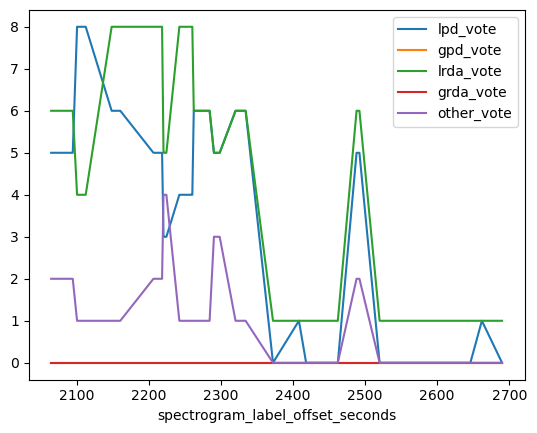

In [17]:
s[['lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote', 'spectrogram_label_offset_seconds']].set_index("spectrogram_label_offset_seconds").plot()

The previous graph gives us the big picture of the target variables and their bifercation. 

## Train the Model

Normalizing the data first with scaling. But here we are trying to target the expert consensus to see alternate results and how does that perform.

In [21]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# encode the target variable
label_encoder = LabelEncoder()
df['expert_consensus_encoded'] = label_encoder.fit_transform(df['expert_consensus'])

features = df.drop(['expert_consensus', 'expert_consensus_encoded'], axis=1)
target = df['expert_consensus_encoded']

# standardize 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# combine for model training
processed_train_df = pd.DataFrame(scaled_features, columns=features.columns)
processed_train_df['expert_consensus_encoded'] = target

processed_train_df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,expert_consensus_encoded
0,-0.386104,-0.376823,-0.377730,-1.695809,-0.419339,-0.358979,-1.621954,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998,5
1,-0.386104,-0.362488,-0.358655,-1.695809,-0.409751,-0.354841,1.406297,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998,5
2,-0.386104,-0.348152,-0.352297,-1.695809,-0.400162,-0.353461,-0.804360,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998,5
3,-0.386104,-0.333817,-0.320506,-1.695809,-0.390574,-0.346563,0.465163,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998,5
4,-0.386104,-0.319482,-0.301432,-1.695809,-0.380985,-0.342425,0.756418,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998,5


### Model Selection and training

To further train the data, we are splitting the data into train and validation sets with 80% and 20% respectively.

Then, we apply the random forest classification to the clustered data with initializing and fitting the data. Further, making predicitons based on accuracy, classification, and confusion matrix.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    processed_train_df.drop('expert_consensus_encoded', axis=1), 
    processed_train_df['expert_consensus_encoded'], 
    test_size=0.2, 
    random_state=42
)

# initialize and fit the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# make predictions
y_pred = rf_classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)
confusion_mat = confusion_matrix(y_val, y_pred)

print(f'The accuracy score is: {accuracy}')
print(f'The random classification score is: {classification_rep}')
print(f'The confusion matrix is: {confusion_mat}')

The accuracy score is: 0.9995318352059925
The random classification score is:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3444
           1       1.00      1.00      1.00      3709
           2       1.00      1.00      1.00      2910
           3       1.00      1.00      1.00      3375
           4       1.00      1.00      1.00      3757
           5       1.00      1.00      1.00      4165

    accuracy                           1.00     21360
   macro avg       1.00      1.00      1.00     21360
weighted avg       1.00      1.00      1.00     21360

The confusion matrix is: [[3443    0    0    0    0    1]
 [   0 3709    0    0    0    0]
 [   0    0 2910    0    0    0]
 [   0    0    0 3373    1    1]
 [   0    0    1    3 3752    1]
 [   0    0    2    0    0 4163]]


With the 99.95% accuracy and perfect precision and recall

## Adjusting the Model for the Test Dataset

In [26]:
# select the features
selected_features = ['spectrogram_id', 'eeg_id', 'patient_id']
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

# retraining the data
rf_classifier_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_selected.fit(X_train_selected, y_train)

y_pred_selected = rf_classifier_selected.predict(X_val_selected)

accuracy_selected = accuracy_score(y_val, y_pred_selected)
classification_rep_selected = classification_report(y_val, y_pred_selected)
confusion_mat_selected = confusion_matrix(y_val, y_pred_selected)

print(f'The selected accuracy score is: {accuracy_selected}')
print(f'The selected random classification score is: \
                                                                {classification_rep_selected}')
print(f'The selected confusion matrix is: \
                                                                {confusion_mat_selected}')

The selected accuracy score is: 0.9317415730337079
The selected random classification score is:                                                                               precision    recall  f1-score   support

           0       0.96      0.96      0.96      3444
           1       0.97      0.96      0.97      3709
           2       0.88      0.91      0.90      2910
           3       0.94      0.97      0.95      3375
           4       0.91      0.86      0.88      3757
           5       0.93      0.93      0.93      4165

    accuracy                           0.93     21360
   macro avg       0.93      0.93      0.93     21360
weighted avg       0.93      0.93      0.93     21360

The selected confusion matrix is:                                                                 [[3300   11   25    4   71   33]
 [  30 3579   11   16   54   19]
 [  30    8 2659   63   88   62]
 [   1   10   50 3265   28   21]
 [  63   73  144   75 3242  160]
 [  25   23  119   42   99 3857]]


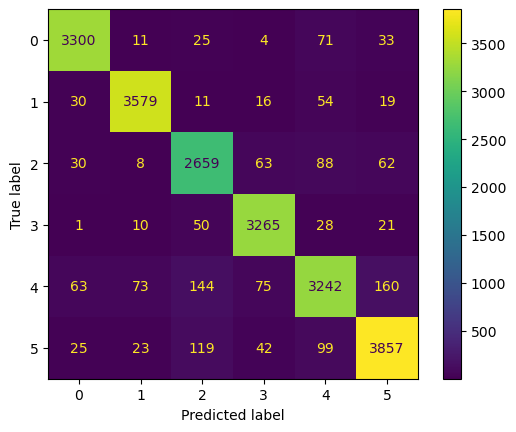

In [27]:
ConfusionMatrixDisplay.from_estimator(rf_classifier_selected, X_val_selected, y_val);

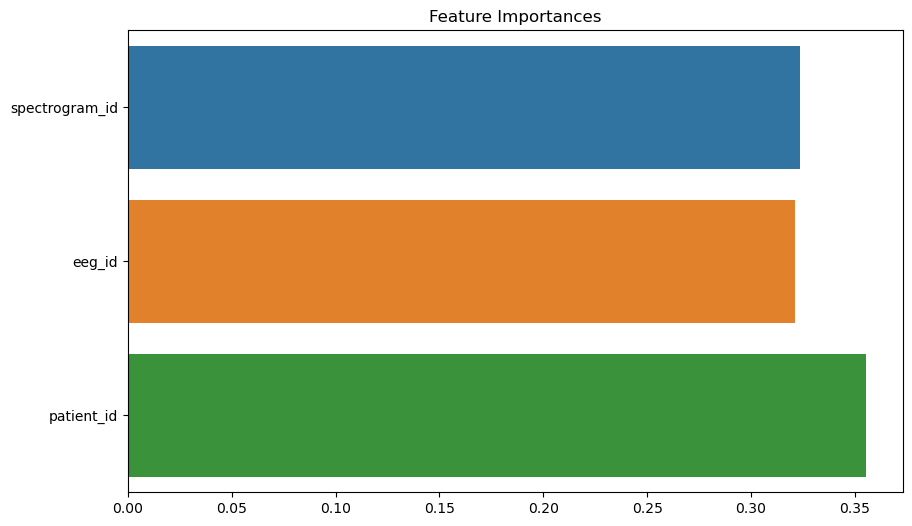

In [28]:
# get feature importances from the Random Forest model
feature_importances = rf_classifier_selected.feature_importances_
features = selected_features

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importances')
plt.show()

## Prediction on Test Data with Selected Features

In [29]:
# fit a new StandardScaler with selected features
scaler_selected = StandardScaler()
scaled_train_selected = scaler_selected.fit_transform(X_train_selected)


scaled_test_features_selected = scaler_selected.transform(df[selected_features])
rf_classifier_selected.fit(scaled_train_selected, y_train)


test_predictions_selected = rf_classifier_selected.predict(scaled_test_features_selected)

# decoding the predictions back to original labels
test_predictions_decoded_selected = label_encoder.inverse_transform(test_predictions_selected)

prediction_df_selected = pd.DataFrame({
    'id': df.index,
    'predicted_seizure': test_predictions_decoded_selected
})

prediction_df_selected.head()

,id,predicted_seizure
0,0,Other
1,1,Other
2,2,Other
3,3,Other
4,4,Other
5,5,Other
6,6,Other
7,7,Other
8,8,Other
9,9,Other


This did not work. The limited selection of the columns and based on just the expert consensus, the value prediction came out wrong.

## Prediction on Test Data with Selected Features and concatenating the files with ids

Here we matched and referenced the train and test files with their respective .parquet files to get a bigger picture of all the target variables,

'seizure_vote', 
'lpd_vote', 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote'_vote

In [18]:
import os

# directories containing the parquet files
eeg_parquet_dir = '/train_eegs/'
spectrogram_parquet_dir = '/train_spectograms/'

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# load and merge corresponding EEG and spectrogram parquet files
def load_and_merge_data(main_df, eeg_parquet_dir, spectrogram_parquet_dir):
    eeg_data = []
    spectrogram_data = []
    
    for _, row in main_df.iterrows():
        if 'eeg_id' in row and 'spectrogram_id' in row:
            eeg_id = row['eeg_id']
            spectrogram_id = row['spectrogram_id']
            
            # load parquet files
            eeg_parquet_path = os.path.join(eeg_parquet_dir, f'train_eegs/{eeg_id}.parquet')
            if os.path.exists(eeg_parquet_path):
                eeg_df = pd.read_parquet(eeg_parquet_path)
                eeg_df['eeg_id'] = eeg_id
                eeg_data.append(eeg_df)
            
            # load parquet files
            spectrogram_parquet_path = os.path.join(spectrogram_parquet_dir, f'train_spectograms/{spectrogram_id}.parquet')
            if os.path.exists(spectrogram_parquet_path):
                spectrogram_df = pd.read_parquet(spectrogram_parquet_path)
                spectrogram_df['spectrogram_id'] = spectrogram_id
                spectrogram_data.append(spectrogram_df)
        else:
            print("Missing eeg_id or spectrogram_id in row:", row)
    
    # concatenate all loaded data
    if eeg_data:
        eeg_data = pd.concat(eeg_data, ignore_index=True)
    else:
        eeg_data = pd.DataFrame()
        
    if spectrogram_data:
        spectrogram_data = pd.concat(spectrogram_data, ignore_index=True)
    else:
        spectrogram_data = pd.DataFrame()
    
    # merge the main dataframe with loaded EEG and spectrogram data
    if not eeg_data.empty:
        merged_df = main_df.merge(eeg_data, on='eeg_id', how='left')
    else:
        merged_df = main_df

    if not spectrogram_data.empty:
        merged_df = merged_df.merge(spectrogram_data, on='spectrogram_id', how='left')
    
    return merged_df

# merge train and test data with corresponding EEG and spectrogram data
train_merged = load_and_merge_data(train_df, eeg_parquet_dir, spectrogram_parquet_dir)
test_merged = load_and_merge_data(test_df, eeg_parquet_dir, spectrogram_parquet_dir)

print("Train Data Merged Shape:", train_merged.shape)
print("Test Data Merged Shape:", test_merged.shape)


Train columns: Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'],
      dtype='object')
Test columns: Index(['spectrogram_id', 'eeg_id', 'patient_id'], dtype='object')
Train Data Merged Shape: (106800, 15)
Test Data Merged Shape: (1, 3)


In [19]:
train_merged.to_csv('train_merged.csv', index=False)
test_merged.to_csv('test_merged.csv', index=False)

Perform the same model selection and prediction based on the merged files. Adding f1 score for better understanding

In [16]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

train_merged = pd.read_csv('train_merged.csv')
test_merged = pd.read_csv('test_merged.csv')


target_columns = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
# remove 'expert_consensus'
unnecessary_columns = ['expert_consensus'] + target_columns
feature_columns = train_merged.columns.difference(unnecessary_columns)

# encode categorical variables
label_encoders = {}
for column in feature_columns:
    if train_merged[column].dtype == 'object':
        le = LabelEncoder()
        train_merged[column] = le.fit_transform(train_merged[column])
        test_merged[column] = le.transform(test_merged[column])
        label_encoders[column] = le

X = train_merged[feature_columns]
y = train_merged[target_columns]

# split the data into training and validation sets again
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# train random forest model for each target
models = {}
for target in target_columns:
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train[target])
    models[target] = rf

    # evaluate the model
    y_pred = rf.predict(X_val)
    accuracy = accuracy_score(y_val[target], y_pred)
    f1 = f1_score(y_val[target], y_pred, average='weighted')
    print(f"Model for {target}: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}")

# prediction on the test set
test_predictions = pd.DataFrame()
test_features = test_merged[feature_columns]

for target in target_columns:
    test_predictions[target] = models[target].predict(test_features)

Model for seizure_vote: Accuracy = 0.8078, F1 Score = 0.7870
Model for lpd_vote: Accuracy = 0.8617, F1 Score = 0.8435
Model for gpd_vote: Accuracy = 0.8897, F1 Score = 0.8748
Model for lrda_vote: Accuracy = 0.8570, F1 Score = 0.8377
Model for grda_vote: Accuracy = 0.8412, F1 Score = 0.8213
Model for other_vote: Accuracy = 0.7162, F1 Score = 0.6767


KeyError: "['eeg_label_offset_seconds', 'eeg_sub_id', 'label_id', 'spectrogram_label_offset_seconds', 'spectrogram_sub_id'] not in index"

Here, we do get a good accuracy, averaging up to 83% for all the seizure votes and making it better to get a prediction overview. 

After aligning the train and test files with their respective.parquet files, we were able to generate a comprehensive dataset that included all target variables:'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', and 'other_vote'. 

Using this consolidated dataset, we performed model selection and prediction, adding the F1 score to provide a more accurate evaluation of model performance. The results demonstrate promising accuracy, with an average of 83% over all seizure votes, showing strong predictive capability. 

This method improves the overall knowledge and effectiveness of the prediction model for the stated target variables through Machine Learning.


But, can we try another model or maybe method like neural networks with time series and image classification,

## Wavenet Neural Network - A deeplearning time series model

In [4]:
# loading the original data again

df = pd.read_csv('train.csv')
target = df.columns[-6:]
print(df.shape )
print('Targets', list(target))
df.head()

(106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [3]:
# grouping the data by 'eeg_id' and aggregate spectrogram_id and spectrogram_label_offset_seconds and minimum value of it
grouped_data = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
grouped_data.columns = ['spec_id','min']

# getting the maximum spectrogram_label_offset_seconds for each 'eeg_id'
max_offset = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
grouped_data['max'] = max_offset

# patient_id for each 'eeg_id'
max_offset = df.groupby('eeg_id')[['patient_id']].agg('first')
grouped_data['patient_id'] = max_offset

# add the target columns for each 'eeg_id'
max_offset = df.groupby('eeg_id')[target].agg('sum')
for t in target:
    grouped_data[t] = max_offset[t].values

# normalize the target values for each 'eeg_id'
y_data = grouped_data[target].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
grouped_data[target] = y_data

max_offset = df.groupby('eeg_id')[['expert_consensus']].agg('first')
grouped_data['target'] = max_offset

grouped_data = grouped_data.reset_index()
print('Train non-overlapp eeg_id shape:', grouped_data.shape )
grouped_data.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


Grouping the data by 'eeg_id', aggregating and calculating the minimum, maximum, and sum of relevant columns while normalizing target values. 
It also extracts the 'patient_id' and 'expert_consensus' for each 'eeg_id' and prints the resulting dataframe and its shape.

It would be easy to convert all .parquet files in a folder to one .npy file for both the ids to get easy for us to iterate over the different frequencies. 

NOTE: THIS HAS BEEN RAN ONLY ONCE TO AVOID TIME WASTAGE AND SPACE

In [ ]:
def convert_parquet_to_npy(folder_path):
    parquet_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]

    # Loop through each .parquet file and convert it to .npy
    for parquet_file in parquet_files:
        # Construct the full path to the .parquet file
        parquet_path = os.path.join(folder_path, parquet_file)
        
        df = pd.read_parquet(parquet_path)
        np_array = df.to_numpy()
        
        # Construct the output .npy file path
        npy_file = parquet_file.replace('.parquet', '.npy')
        npy_path = os.path.join(folder_path, npy_file)
        
        np.save(npy_path, np_array)
        print(f'Converted {parquet_file} to {npy_file} in {folder_path}')

# Specify the paths to the two folders containing the .parquet files
folder_path1 = '/eegs_specs/'
folder_path2 = '/specs/'

# Convert .parquet files in both folders
convert_parquet_to_npy(folder_path1)
convert_parquet_to_npy(folder_path2)

In [4]:
# load the numpy arrays containing EEG and spectrogram data
eegs = np.load('eeg_specs.npy',allow_pickle=True).item()
spectograms = np.load('specs.npy',allow_pickle=True).item()

In [9]:
import albumentations as albu
import torch
from torch.utils.data import Dataset

# defining the mappings for target labels
labels = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
labels2 = {x: y for y, x in labels.items()}

# a custom dataset class for loading EEG data
class EEGDataset(Dataset):
    def __init__(self, data, spectrograms, eegs, transform=None, mode='grouped_data'):
        self.data = data
        self.spectrograms = spectograms
        self.eegs = eegs
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        if self.mode == 'test':
            r = 0
        else:
            r = int((row['min'] + row['max']) // 4)
            
        # initializing array for the input data
        X = np.zeros((128, 256, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')

        # extract and process spectogram data
        img = np.ones((128, 256), dtype='float32')
        for j in range(4):
            # exatracting 300 rows of the spectogram
            img = self.spectograms[row.spec_id][r:r + 300, j * 100:(j + 1) * 100].T

            # log tranform of spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # standardizing every image
            ep = 1e-6
            m = np.nanmean(img.flatten())
            stdz = np.nanstd(img.flatten())
            img = (img - m) / (stdz + ep)
            img = np.nan_to_num(img, nan=0.0)

            # cropping to 256 time steps
            X[14:-14, :, j] = img[:, 22:-22] / 2.0

        # eeg to spectrograms
        img = self.eegs[row.eeg_id]
        X[:, :, 4:] = img

        if self.mode != 'test':
            y = row[target]
        if self.transform:
            X = self.transform(image=X)['image']

        X = torch.tensor(X)
        y = torch.tensor(y)
        return X, y

    def __random_transform(self, img):
        # applying random transformations to the image
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
        ])
        return composition(image=img)['image']

    def __augment_batch(self, img1):
        for i in range(img1.shape[0]):
            img1[i, ] = self.__random_transform(img1[i, ])
        return img1

This defines a custom PyTorch dataset class EEGDataset for loading and processing EEG and spectrogram data, applying transformations, and preparing it for a WaveNet neural network model. 

The data is standardized, log-transformed, and randomly augmented. The class handles data in both training and testing modes, providing inputs and target labels for the neural network.

Now, we create an instance of the EEGDataset, load it into a PyTorch DataLoader with a batch size of 32, and shuffle the data. 

C:\Users\kalra\AppData\Local\Temp\ipykernel_10588\864675329.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)


torch.Size([32, 128, 256, 8]) torch.Size([32, 6])


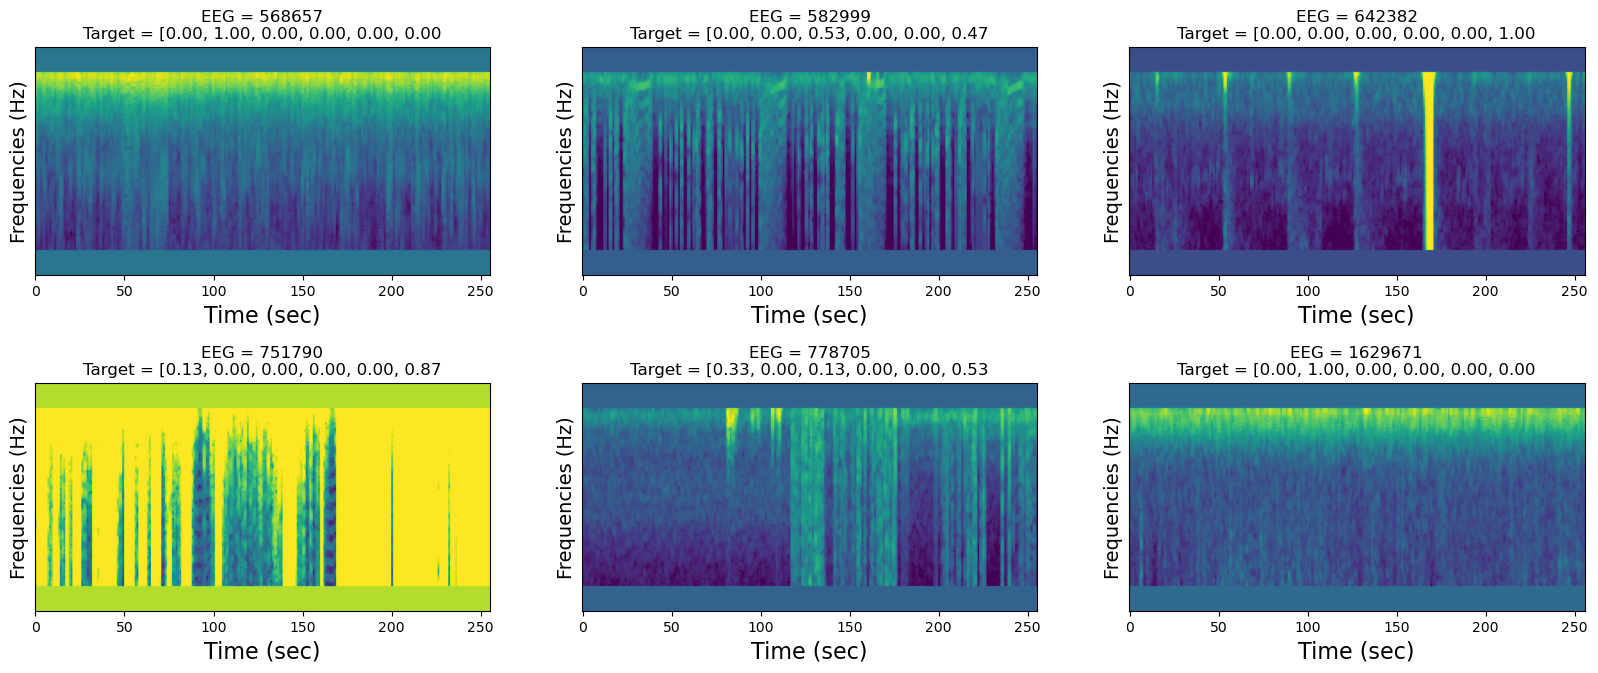

torch.Size([32, 128, 256, 8]) torch.Size([32, 6])


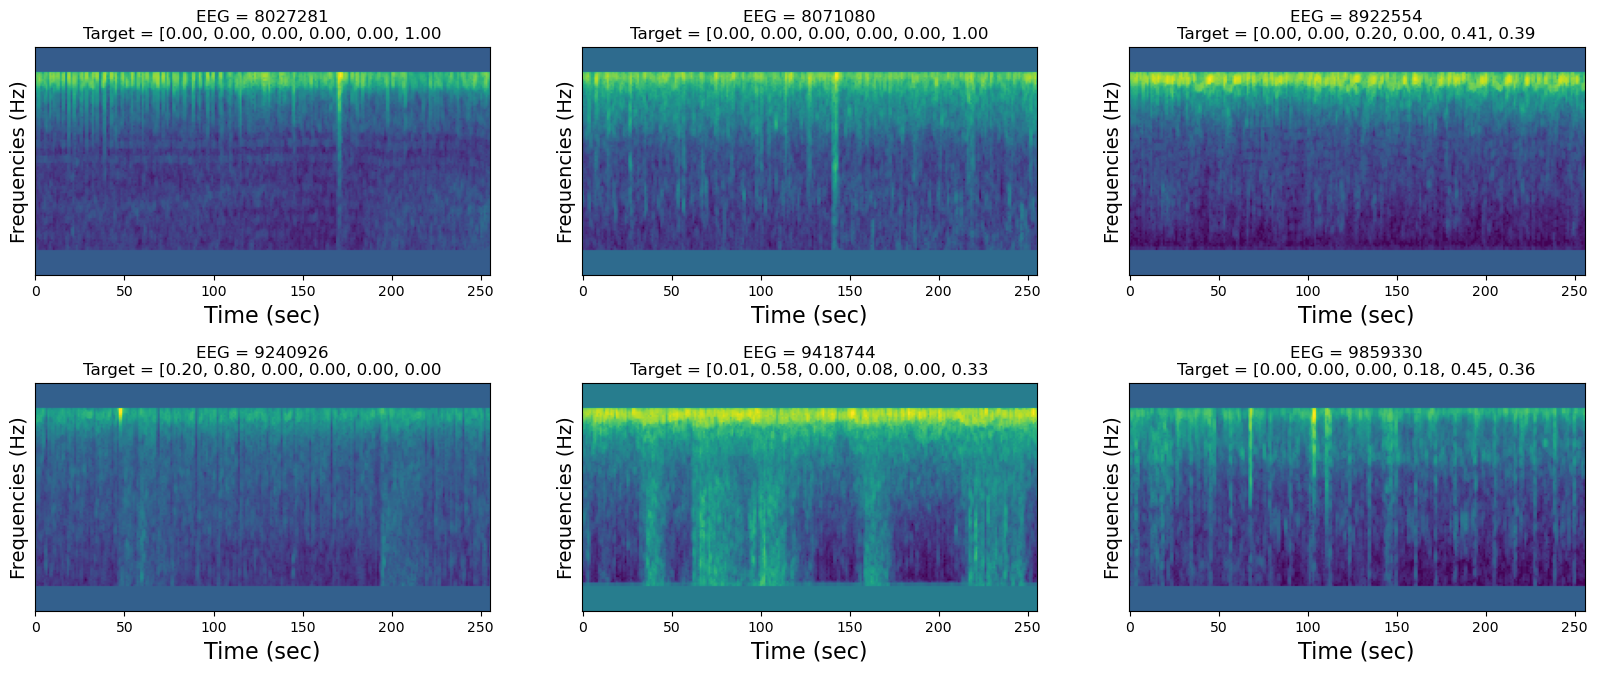

In [14]:
from torch.utils.data import DataLoader
import matplotlib.pylab as plt

# creating an instance 
dataset = EEGDataset(grouped_data, spectograms, eegs)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

rows=2; 
cols=3; 
batches=2

for i,(x,y) in enumerate(dataloader):
    print(x.shape, y.shape)
    
    plt.figure(figsize=(20,8))
    
    for j in range(rows):
        for k in range(cols):
            plt.subplot(rows,cols,j*cols+k+1)

            # getting target values for the current sample
            t = y[j*cols+k]

            # getting image data for the current sample and normalize
            img = x[j*cols+k,:,:,0]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            
            plt.imshow(img)

            # creating label for the target values
            label = f'[{t[0]:0.2f}'
            for s in t[1:]: label += f', {s:0.2f}'
                
            eeg = grouped_data.eeg_id.values[i*32+j*cols+k]
            
            plt.title(f'EEG = {eeg}\nTarget = {label}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
            
    plt.show()
    if i==batches-1: break

Then iterating through the DataLoader, plotting the spectrogram images for each sample in a grid layout. The images are normalized, and each subplot is labeled with the corresponding target values and EEG ID.

# In Conclusion

The notebook effectively sets up the data pipeline for the WaveNet neural network model, including data loading, augmentation, and visualization. 

By iterating through batches, it displays spectrograms and their corresponding target labels, providing a clear understanding of the dataset's structure and preparation steps. 
This visualization aids in verifying the correctness of the data preprocessing pipeline and ensures the model receives accurately processed inputs. 

The approach ensures a robust preparation of EEG data for subsequent training and evaluation phases.

NOTE: Spectrogram might have different spelling while creating folders and some variables but the meaning stays the same.

Resources used: stackoverflow, geekforgeek, chatgpt, and kaggle